In [1]:
import torch
import copy
from torch.utils.data import DataLoader
import json
from datasets import load_dataset
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from transformers.optimization import AdamW
from common_code import *

In [2]:
model_title = "pythia-410M-deduped"

n_new_models = 5 
noise_variance =  0.01
bs = 8
samplelength = 50
nbatches =  500
print(model_title, n_new_models, noise_variance, bs, samplelength, nbatches)

In [3]:
model_name = "EleutherAI/" + model_title
model_revision = "step143000"
model_cache_dir = "./"+ model_title +"/"+model_revision

model = GPTNeoXForCausalLM.from_pretrained(
  model_name,
  revision=model_revision,
  cache_dir=model_cache_dir,
)

tokenizer = AutoTokenizer.from_pretrained(
  model_name,
  revision=model_revision,
  cache_dir=model_cache_dir,
)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.half()
model.eval()
model.to(device)
mem_stats()

Total Memory: 15.77 GB
Reserved Memory: 0.86 GB (5.46%)
Remaining Memory: 14.91 GB (94.54%)
---------------------------------
Allocated Memory: 0.85 GB (5.38%)
Percent of Reserved Allocated: 98.54%



In [4]:
## Collate functions for loading dataset
def collate_fn(batch):
    tokens = [tokenizer.encode(example["text"], return_tensors="pt", truncation=True) for example in batch]
    max_length = max([t.size(1) for t in tokens])
    tokens_padded = [torch.cat([t, t.new_zeros(t.size(0), max_length - t.size(1))], dim=1) for t in tokens]
    tokens_padded = torch.cat(tokens_padded, dim=0)
    return tokens_padded

def collate_already_encoded(batch):
    tokens = batch
    max_length = max([len(t['tokens']) for t in tokens])
    tokens_padded = torch.zeros((len(tokens),max_length),dtype=torch.int)
    for i in range(len(tokens)):
        tokens_padded[i,:] = torch.Tensor(tokens[i]['tokens'])
    return tokens_padded

In [5]:
def compare_models(new_model, n_new_models, noise_variance, 
                   dataloader, nbatches, bs, samplelength, device):
  
  new_model.eval()
  new_model.to(device)
  ans = torch.zeros((n_new_models+1, nbatches, bs))  
  
  ans[0,:,:] = compute_dataloader_cross_entropy(dataloader, nbatches, bs, device, new_model, samplelength)

  for ind_model in range(1,n_new_models+1):
    prevseed = torch.seed()
    with torch.no_grad():
      for param in new_model.parameters():
          param.add_((torch.randn(param.size()) * noise_variance).to(device))
    
    ans[ind_model,:,:] = compute_dataloader_cross_entropy(dataloader, nbatches, bs, device, new_model, samplelength)

    torch.manual_seed(prevseed)
    with torch.no_grad():
      for param in new_model.parameters():
          param.add_(-(torch.randn(param.size()) * noise_variance).to(device))

    if ind_model % 5 == 0:
      print(ind_model)
      mem_stats()
  return ans 

In [6]:
training_dataset = load_dataset("EleutherAI/pile-deduped-pythia-random-sampled", split="train")
validation_dataset = load_dataset("the_pile_val.py", split="validation") 

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/EleutherAI___parquet/EleutherAI--pile-deduped-pythia-random-sampled-ef6db9ddd170a4bc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
No config specified, defaulting to: the_pile_val/all
Found cached dataset the_pile_val (/home/ubuntu/.cache/huggingface/datasets/the_pile_val/all/0.0.0/33c9237089c5fb09f83b2ab7ac73d703de97fc4d122e4b82a7777d85b0919e30)


In [7]:
training_dataloader = DataLoader(training_dataset, batch_size = bs, collate_fn=collate_already_encoded)
validation_dataloader = DataLoader(validation_dataset, batch_size = bs, collate_fn=collate_fn)

In [8]:
training = compare_models(model, n_new_models, noise_variance, training_dataloader, nbatches, bs, samplelength, device)
validation = compare_models(model, n_new_models, noise_variance, validation_dataloader, nbatches, bs, samplelength, device)

batch no.  0
Memory after evaluation
Total Memory: 15.77 GB
Reserved Memory: 0.88 GB (5.58%)
Remaining Memory: 14.89 GB (94.42%)
---------------------------------
Allocated Memory: 0.86 GB (5.43%)
Percent of Reserved Allocated: 97.26%


batch no.  50
Memory after evaluation
Total Memory: 15.77 GB
Reserved Memory: 0.88 GB (5.58%)
Remaining Memory: 14.89 GB (94.42%)
---------------------------------
Allocated Memory: 0.86 GB (5.43%)
Percent of Reserved Allocated: 97.26%


batch no.  100
Memory after evaluation
Total Memory: 15.77 GB
Reserved Memory: 0.88 GB (5.58%)
Remaining Memory: 14.89 GB (94.42%)
---------------------------------
Allocated Memory: 0.86 GB (5.43%)
Percent of Reserved Allocated: 97.26%


batch no.  150
Memory after evaluation
Total Memory: 15.77 GB
Reserved Memory: 0.88 GB (5.58%)
Remaining Memory: 14.89 GB (94.42%)
---------------------------------
Allocated Memory: 0.86 GB (5.43%)
Percent of Reserved Allocated: 97.26%


batch no.  200
Memory after evaluation
Total Me

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


5
Total Memory: 15.77 GB
Reserved Memory: 1.27 GB (8.04%)
Remaining Memory: 14.50 GB (91.96%)
---------------------------------
Allocated Memory: 0.86 GB (5.43%)
Percent of Reserved Allocated: 67.59%

batch no.  0
Memory after evaluation
Total Memory: 15.77 GB
Reserved Memory: 0.88 GB (5.58%)
Remaining Memory: 14.89 GB (94.42%)
---------------------------------
Allocated Memory: 0.86 GB (5.43%)
Percent of Reserved Allocated: 97.26%


batch no.  50
Memory after evaluation
Total Memory: 15.77 GB
Reserved Memory: 0.88 GB (5.58%)
Remaining Memory: 14.89 GB (94.42%)
---------------------------------
Allocated Memory: 0.86 GB (5.43%)
Percent of Reserved Allocated: 97.26%


batch no.  100
Memory after evaluation
Total Memory: 15.77 GB
Reserved Memory: 0.88 GB (5.58%)
Remaining Memory: 14.89 GB (94.42%)
---------------------------------
Allocated Memory: 0.86 GB (5.43%)
Percent of Reserved Allocated: 97.26%


batch no.  150
Memory after evaluation
Total Memory: 15.77 GB
Reserved Memory: 0.88 G

In [10]:
train_flat = training.flatten(start_dim=1)
valid_flat = validation.flatten(start_dim=1)

train_diff = train_flat[0,:]-train_flat[1:,:].mean(dim=0)
valid_diff = valid_flat[0,:]-valid_flat[1:,:].mean(dim=0)


In [11]:
torch.save(torch.vstack((train_flat, valid_flat)), 
model_title + " Perturbation attack (#new models="+str(n_new_models)
                                      +", noise_var="+str(noise_variance)
                                      + ", bs=" + str(bs)
                                      +", nbatches="+str(nbatches)
                                      +", length="+str(samplelength)+").pt")


tensor(-4.2039) tensor(-0.0796)


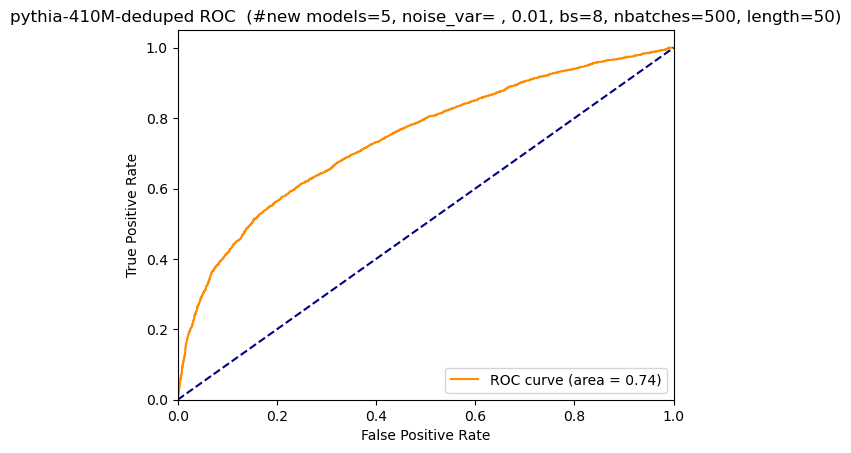

<Figure size 640x480 with 0 Axes>

In [12]:
plot_ROC(train_diff, valid_diff, show_plot = True, save_plot = True, log_scale = False, 
        plot_title =model_title + " ROC  (#new models="+str(n_new_models)
                                      +", noise_var= "+str(noise_variance)
                                      +", bs=" + str(bs)
                                      +", nbatches="+str(nbatches)
                                      +", length="+str(samplelength)+")", 
        plot_name = model_title + " ROC (#new models="+str(n_new_models)
                                      +", noise_var="+str(noise_variance)
                                      + ", bs=" + str(bs)
                                      +", nbatches="+str(nbatches)
                                      +", length="+str(samplelength)+").png")



tensor(-4.2039) tensor(-0.0796)


/home/ubuntu/common_code.py:143: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0.0, 1.0])
/home/ubuntu/common_code.py:144: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0.0, 1.05])


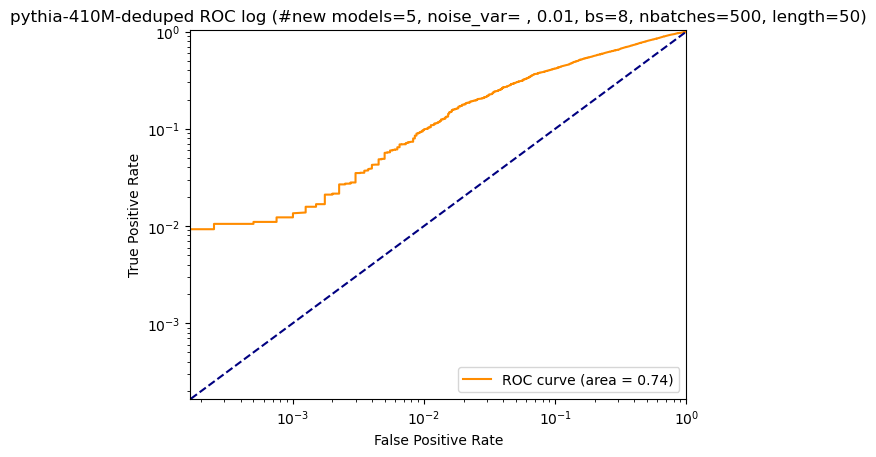

<Figure size 640x480 with 0 Axes>

In [13]:
plot_ROC(train_diff, valid_diff, show_plot = True, save_plot = True, log_scale = True, 
        plot_title =model_title + " ROC log (#new models="+str(n_new_models)
                                      +", noise_var="+str(noise_variance)
                                      +", bs=" + str(bs)
                                      +", nbatches="+str(nbatches)
                                      +", length="+str(samplelength)+")", 
        plot_name = model_title + " ROC log (#new models="+str(n_new_models)
                                      +", noise_var="+str(noise_variance)
                                      + ", bs=" + str(bs)
                                      +", nbatches="+str(nbatches)
                                      +", length="+str(samplelength)+").png")
